## Brain Tumor Detection


<a id="section-one"></a>
##  Classification

In this part of the notebook, the main aim is to create a model able to distinguish between MRI images of patients affected by a brain tumor and the ones of healthy subjects.

To achieve this aim, instead of using a pre-trained model, as done in the other published notebooks, I decided to build a simple Convolutional Neural Network from scratch. 

Considering that one of the greatest limitations of Deep learning is the interpretability of the models, I wanted to see if a simpler and more interpretable model could achieve or even overcome the results obtained in the other notebooks with deeper models.


In [1]:
#%% IMPORTING LIBRARIES that needed in the project

import os
import glob
import shutil
import random
import pandas as pd
from PIL import Image
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#%% IMPORTING the dataset that we will work on it 

def importing_data(path):
    sample = [] 
    for filename in glob.glob(path): #uploading the required data  
        #img = Image.open(filename,'r')
        #IMG = np.array(img)
        sample.append(filename)
    return sample
#the path of the dataset 
path1 = '//kaggle/input/brain-tumor-detection/no/*.jpg' #data of healthy brain 
path2 = '//kaggle/input/brain-tumor-detection/yes/*.jpg' #brain with tumour 
path3 = '//kaggle/input/brain-tumor-detection/pred/*.jpg' #testing file of the images

#importing the data into a variables 
train_n = importing_data(path1)
train_y = importing_data(path2)
test = importing_data(path3)

#%% CREATION OF DATASETS 
#for easy acess to the data labeling each folder in a csv form weather it is a healthy or affected brain 

df_train_n = pd.DataFrame({'image':train_n, 'label': 'Healthy'})
df_train_y = pd.DataFrame({'image':train_y, 'label': 'Affected'})
df_test = pd.DataFrame({'image':test})
train_data = pd.concat([df_train_n, df_train_y])
train_data

,image,label
0,//kaggle/input/brain-tumor-detection/no/no26.jpg,Healthy
1,//kaggle/input/brain-tumor-detection/no/no979.jpg,Healthy
2,//kaggle/input/brain-tumor-detection/no/no598.jpg,Healthy
3,//kaggle/input/brain-tumor-detection/no/no141.jpg,Healthy
4,//kaggle/input/brain-tumor-detection/no/no715.jpg,Healthy
...,...,...
1495,//kaggle/input/brain-tumor-detection/yes/y1379...,Affected
1496,//kaggle/input/brain-tumor-detection/yes/y1452...,Affected
1497,//kaggle/input/brain-tumor-detection/yes/y378.jpg,Affected
1498,//kaggle/input/brain-tumor-detection/yes/y178.jpg,Affected


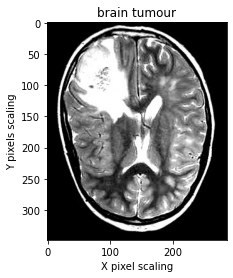

In [3]:
#a visualzation sample of the cancerous image 

from matplotlib import pyplot as plt
from matplotlib import image as mpimg
 
plt.title("brain tumour")
plt.xlabel("X pixel scaling")
plt.ylabel("Y pixels scaling")
 
image = mpimg.imread("/kaggle/input/brain-tumor-detection/yes/y0.jpg")
plt.imshow(image)
plt.show()

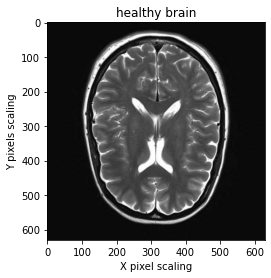

In [4]:
#a visualzation sample of a non cancerous image 

from matplotlib import pyplot as plt
from matplotlib import image as mpimg
 
plt.title("healthy brain")
plt.xlabel("X pixel scaling")
plt.ylabel("Y pixels scaling")
 
image = mpimg.imread("/kaggle/input/brain-tumor-detection/no/No12.jpg")
plt.imshow(image)
plt.show()

In [5]:
#%% TRAIN-VALIDATION SPLIT (90% TRAIN - 10% VALIDATION) 

from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(train_data,
                                  test_size = 0.1,
                                  shuffle = True,
                                  random_state = 42)

<a id="subsection-one"></a>
### CREATING THE CNN MODEL

In [6]:
#%% CREATING THE CNN MODEL 
#from the following we will start to create a cnn model from the start for the dataset 
import keras
from keras.metrics import AUC, Recall, Precision
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D , MaxPooling2D, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import RMSprop

def build_model():
    
    '''Sequential Model creation'''
    Cnn = Sequential()
    
    Cnn.add(Conv2D(64,(5,5), activation = 'relu', padding = 'same',
                   strides=(2,2), input_shape = [224,224,1]))
    Cnn.add(MaxPooling2D(2))
    Cnn.add(Conv2D(128,(5,5), activation = 'relu', padding = 'same', strides=(2,2)))
    Cnn.add(Conv2D(128,(5,5), activation = 'relu', padding = 'same', strides=(2,2)))
    Cnn.add(Conv2D(256,(5,5), activation = 'relu', padding = 'same', strides=(2,2)))
    Cnn.add(MaxPooling2D(2))
    #Cnn.add(GlobalAveragePooling2D())
    Cnn.add(Flatten()) #from 2d image to 1d image to make the prediction more better
    Cnn.add(Dense(64, activation = 'relu'))
    Cnn.add(Dropout(0.4))
    Cnn.add(Dense(32, activation = 'relu'))
    Cnn.add(Dropout(0.4))
    Cnn.add(Dense(2, activation = 'softmax'))
    
    return Cnn

keras_model = build_model()
keras_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 112, 112, 64)      1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 128)       204928    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       409728    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 256)         819456    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0

In [7]:
#%% FITTING THE MODEL

def Model_fit(train_data, val_data):
    
    keras_model = None
    
    keras_model = build_model()
    
    '''Compiling the model'''
    
    keras_model.compile(optimizer = RMSprop(learning_rate = 1e-4),
                        loss='sparse_categorical_crossentropy',
                        metrics =['acc'])
    
    es = EarlyStopping(monitor='val_loss', mode='min',
                       patience=2,
                       restore_best_weights=True,
                       verbose=1)
                       
    
    checkpoint_cb = ModelCheckpoint("Brain_model_best.h5",
                                    save_best_only=True)
    
    reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                                  factor = 0.2,
                                  patience = 3,
                                  min_lr = 1e-5,
                                  mode = 'min',
                                  verbose=1)
                                  
    
    history = keras_model.fit(train_data,
                              validation_data = val_data,
                              epochs= 50,
                              batch_size = 10,
                              callbacks=[es, checkpoint_cb, reduce_lr])
                              
    
      
    return history

In [8]:
#training of the model
from keras.preprocessing.image import ImageDataGenerator

k_fold = 3
IMG_SIZE = 224
size = (IMG_SIZE,IMG_SIZE)
n_CLASS = 2

def CV_training(train_data, val_data):
    
    cv_histories = []
    
    for i in range(0,k_fold):
    
        datagen = ImageDataGenerator(rescale = 1./255)
    
        train_set = datagen.flow_from_dataframe(train_data,
                                                directory = '//kaggle/input/brain-tumor-detection/*.jpg',
                                                x_col = 'image',
                                                y_col = 'label',
                                                target_size = size,
                                                color_mode = 'grayscale',
                                                class_mode = 'sparse',
                                                batch_size = 10,
                                                shuffle = True,
                                                interpolation = 'bilinear')
        
        val_set = datagen.flow_from_dataframe(val_data,
                                              directory = '//kaggle/input/brain-tumor-detection/*.jpg',
                                              x_col = 'image',
                                              y_col = 'label',
                                              target_size = size,
                                              color_mode = 'grayscale',
                                              class_mode = 'sparse',
                                              batch_size = 10,
                                              shuffle = True,
                                              interpolation = 'bilinear')
        print("Training on Fold: ",i+1)
    
        cv_histories.append(Model_fit(train_set, val_set))
    
    return cv_histories

cv_results = CV_training(X_train,X_val)

Found 2700 validated image filenames belonging to 2 classes.
Found 300 validated image filenames belonging to 2 classes.
Training on Fold:  1
Epoch 1/50
270/270 [==============================] - 76s 281ms/step - loss: 0.6095 - acc: 0.6715 - val_loss: 0.5179 - val_acc: 0.7433
Epoch 2/50
270/270 [==============================] - 74s 275ms/step - loss: 0.5150 - acc: 0.7578 - val_loss: 0.4462 - val_acc: 0.8200
Epoch 3/50
270/270 [==============================] - 74s 272ms/step - loss: 0.4099 - acc: 0.8256 - val_loss: 0.3444 - val_acc: 0.8633
Epoch 4/50
270/270 [==============================] - 74s 274ms/step - loss: 0.3282 - acc: 0.8704 - val_loss: 0.2295 - val_acc: 0.9000
Epoch 5/50
270/270 [==============================] - 74s 275ms/step - loss: 0.2383 - acc: 0.9144 - val_loss: 0.1776 - val_acc: 0.9400
Epoch 6/50
270/270 [==============================] - 75s 278ms/step - loss: 0.1755 - acc: 0.9422 - val_loss: 0.1221 - val_acc: 0.9433
Epoch 7/50
270/270 [============================

In [9]:
#%% CHEKING THE CROSS VALIDATION METRICS 
#to check the accuracy of the training model 

def acc_results(results):
    i = 0
    for fold in cv_results:
        print('Val_Acc Folder '+ str(i) + ' =', max(fold.history['val_acc']))
        i += 1
        
acc_results(cv_results)

Val_Acc Folder 0 = 0.996666669845581
Val_Acc Folder 1 = 0.9900000095367432
Val_Acc Folder 2 = 0.996666669845581


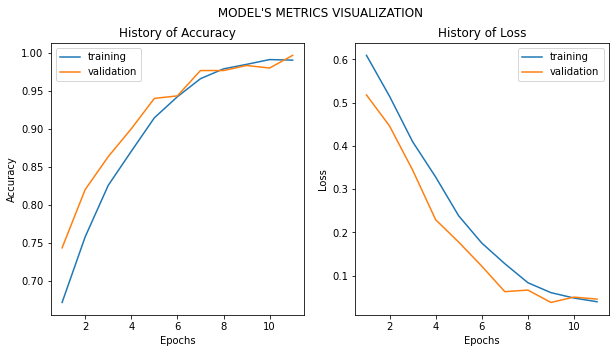

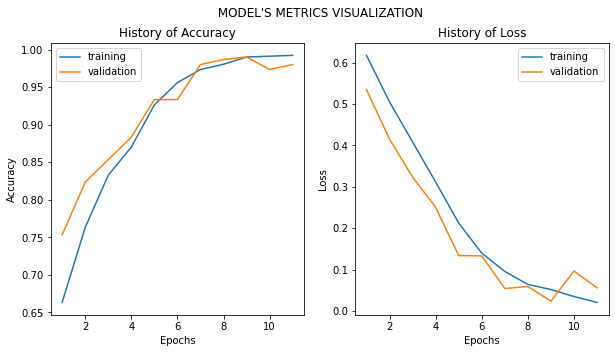

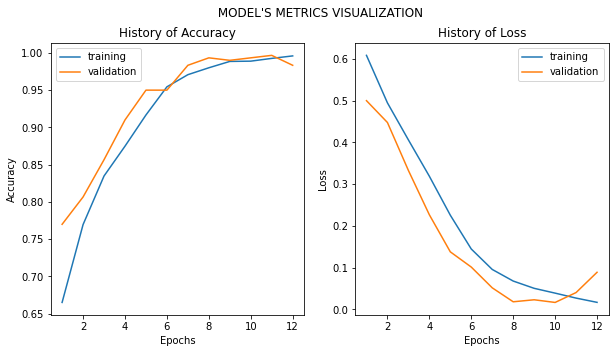

In [10]:
#%% LOOKING AT THE ACCURACY-LOSS PLOTS FOR EACH FOLD

def Acc_Loss_Plot(results):
    
    for fold in results:
        
        acc = fold.history['acc']
        val_acc = fold.history['val_acc']
        loss = fold.history['loss']
        val_loss = fold.history['val_loss']
    
        fig, (ax1, ax2) = plt.subplots(1,2, figsize= (10,5))
        fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

        ax1.plot(range(1, len(acc) + 1), acc)
        ax1.plot(range(1, len(val_acc) + 1), val_acc)
        ax1.set_title('History of Accuracy')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Accuracy')
        ax1.legend(['training', 'validation'])


        ax2.plot(range(1, len(loss) + 1), loss)
        ax2.plot(range(1, len(val_loss) + 1), val_loss)
        ax2.set_title('History of Loss')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Loss')
        ax2.legend(['training', 'validation'])
        plt.show()
    
Acc_Loss_Plot(cv_results)

In [11]:
#%% LOADING THE MODEL

import keras

keras_model = keras.models.load_model('Brain_model_best.h5')
keras_model.compile(optimizer = RMSprop(learning_rate = 1e-4),
                    loss='sparse_categorical_crossentropy', metrics =[ 'acc'])

# Predictions on the test set

datagen = ImageDataGenerator(rescale = 1./255)

test_set = datagen.flow_from_dataframe(df_test,
                                       directory = '//kaggle/input/brain-tumor-detection/*.jpg',
                                       x_col = 'image',
                                       y_col = None,
                                       target_size = size,
                                       color_mode = 'grayscale',
                                       class_mode = None,
                                       batch_size = 10,
                                       shuffle = False,
                                       interpolation = 'bilinear')

predictions = keras_model.predict(test_set)
predictions = predictions.argmax(axis=-1)
print("Where 0 = 'Affected'")
print("Where 1 = 'Healthy'")
print(predictions)


Found 60 validated image filenames.
Where 0 = 'Affected'
Where 1 = 'Healthy'
[1 0 0 1 0 0 1 0 0 0 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 0 0 1 1 0 1 0
 0 1 0 1 1 1 0 1 1 0 1 0 1 1 1 1 0 0 1 1 0 0 1]


In [12]:
pred = []
[pred.append('Healthy') if i == 1 else pred.append('Affected') for i in predictions]
print(pred)

['Healthy', 'Affected', 'Affected', 'Healthy', 'Affected', 'Affected', 'Healthy', 'Affected', 'Affected', 'Affected', 'Healthy', 'Affected', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Affected', 'Affected', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Affected', 'Affected', 'Healthy', 'Healthy', 'Healthy', 'Affected', 'Affected', 'Healthy', 'Healthy', 'Affected', 'Healthy', 'Affected', 'Affected', 'Healthy', 'Affected', 'Healthy', 'Healthy', 'Healthy', 'Affected', 'Healthy', 'Healthy', 'Affected', 'Healthy', 'Affected', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Affected', 'Affected', 'Healthy', 'Healthy', 'Affected', 'Affected', 'Healthy']


In [13]:
#%% OBTAINING PREDICTIONS OF THE FIRST BATCH
    
images10 = [test_set[0][0],test_set[0][1],test_set[0][2],test_set[0][3],test_set[0][4],
            test_set[0][5],test_set[0][6],test_set[0][7],test_set[0][8],test_set[0][9]]
            
prediction10 = pred[0:9]
final_pred = zip(images10,prediction10)

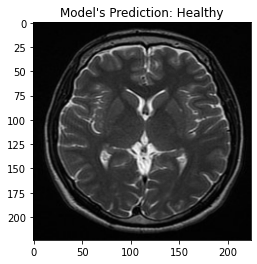

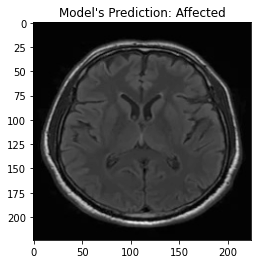

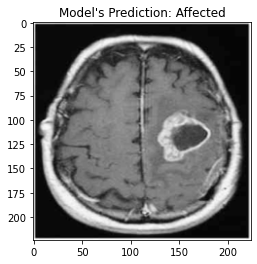

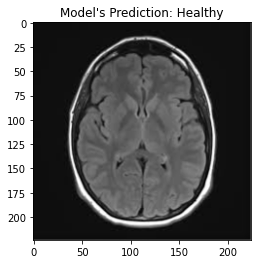

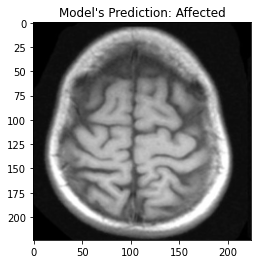

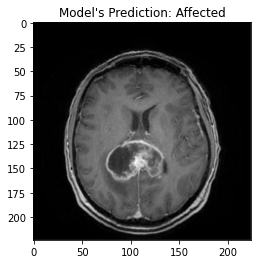

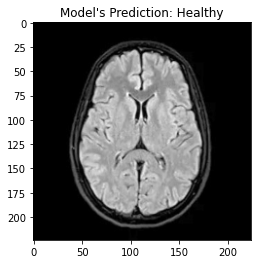

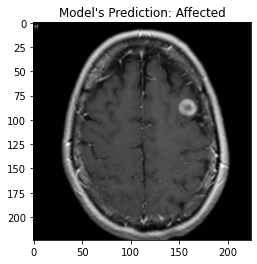

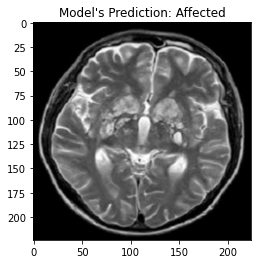

In [14]:
def pre_visualization(data, predictions):
    
    for image,pred in final_pred:
        plt.imshow(image.reshape(224,224), cmap = 'gray')
        plt.title("Model's Prediction: " + str(pred))
        plt.show()
        
pre_visualization(images10,prediction10)